In [1]:
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library, Medium, Structure

import autograd
from autograd.tracer import getval
import autograd.numpy as anp
from typing import List, Tuple

import matplotlib.pylab as plt
import numpy as np
import os
import optax

## Create Simulation Structures

### Define basic simulation parameters

Most custom parameters are defined in the following block. However, the `param_to_design_info` needs to be carefully reviewed if the structure has changes in the layer numbers and dielectric/metal combinations as it is tightly bound to a specific structure.

In [2]:
Ni = material_library["Ni"]["RakicLorentzDrude1998"]  # Valid for 0.25 - 6.2 um
SiO2 = Medium(permittivity=2.08, name="SiO2")

bandwidth = 0.25  # microns
wvl_range = (3.30, 5.20)  # microns
freq_range = (td.C_0 / wvl_range[1], td.C_0 / wvl_range[0])

wvl0 = np.mean(wvl_range)
freq0 = td.C_0 / wvl0

print(f"Center frequency:\t{freq0: .2e} Hz")
print(f"Center wavelength:\t{wvl0} um")
print(f"Target bandwidth:\t{bandwidth} um")
print(f"Frequency range:\t[{freq_range[0]: .2e}, {freq_range[1]: .2e}] Hz")
print(f"Wavelength range:\t{wvl_range} um")

fwidth = td.constants.C_0 / wvl_range[0] - td.constants.C_0 / wvl_range[1]
run_time = 300 / fwidth
shutoff = 1e-4

print(f"\nSource frequency width:\t{fwidth: .2e} Hz")
print(f"Run time:\t\t{run_time: .2e} s")
print(f"Shutoff:\t\t{shutoff: .2e} W/m^2")

#monitor_wvls = np.array([3.3, 3.395, 3.604, 3.794, 3.90, 3.95, 4.098, 4.15, 4.25, 4.32, 4.402, 4.497, 4.592, 4.706, 4.801, 4.953, 5.2])
#monitor_freqs = td.constants.C_0 / monitor_wvls
#wvl_points = 17

wvl_points = 17
monitor_wvls = np.linspace(wvl_range[0], wvl_range[1], wvl_points)
monitor_freqs = td.constants.C_0 / monitor_wvls
dl_monitor_wvls = (wvl_range[1] - wvl_range[0]) / (wvl_points - 1)

print(f"\nMonitor frequency range: [{monitor_freqs[0]: .2e}, {monitor_freqs[-1]: .2e}] Hz")

buffer_size = 0.1  # distance between the source and the monitor
distance = wvl0  # distance between the source/monitor/structure and the PML

# Define the structure constraints
# Default substrate values
sub_metal_thickness = 0.2
sub_dielectric_thickness = 0.25
num_of_sub_layers = 2
# Substrate constraints
sub_metal_min_thickness = 0.1
sub_metal_max_thickness = 0.3
sub_dielectric_min_thickness = 0.15
sub_dielectric_max_thickness = 0.35
sub_thickness_constraints_min = [sub_metal_min_thickness, sub_dielectric_min_thickness]
sub_thickness_constraints_max = [sub_metal_max_thickness, sub_dielectric_max_thickness]

# Default cuboid values
cuboid_metal_thickneness = 0.025
cuboid_dielectric_thickness = 0.1
num_of_cuboid_layers = 2 * 5  # 5 bilayers
# Cuboid constraints
cuboid_min_length = 1.0
cuboid_max_length = 3.4
cuboid_min_width = 1.0
cuboid_max_width = 3.4
cuboid_metal_min_thickness = 0.015
cuboid_metal_max_thickness = 0.035
cuboid_dielectric_min_thickness = 0.05
cuboid_dielectric_max_thickness = 0.2
cuboid_thickness_constraints_min = [
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
    cuboid_metal_min_thickness,
    cuboid_dielectric_min_thickness,
]
cuboid_thickness_constraints_max = [
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
    cuboid_metal_max_thickness,
    cuboid_dielectric_max_thickness,
]

sub_materials = [Ni, SiO2]
cuboid_materials = [Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2]

# Simulation domain
Lx = 3.5
Ly = 3.5
Lz = (
    2 * wvl0
    + buffer_size
    + distance
    + sub_metal_max_thickness
    + sub_dielectric_max_thickness
    + 5 * (cuboid_metal_max_thickness + cuboid_dielectric_max_thickness)
)
min_steps_per_wvl = 10  # outside of structure
# fine discretization in propagation direction
# make sure to double-check discretization in xy
override_dl = (0.1, 0.1, 0.005)

Center frequency:	 7.05e+13 Hz
Center wavelength:	4.25 um
Target bandwidth:	0.25 um
Frequency range:	[ 5.77e+13,  9.08e+13] Hz
Wavelength range:	(3.3, 5.2) um

Source frequency width:	 3.32e+13 Hz
Run time:		 9.04e-12 s
Shutoff:		 1.00e-04 W/m^2

Monitor frequency range: [ 9.08e+13,  5.77e+13] Hz


### Define source and monitor objects

In [3]:
SOURCE_PLANEWV_NAME = "source_planewave"
FLUX_MONITOR_NAME = "monitor_flux"

source_planewave = td.PlaneWave(
    center=(0, 0, Lz / 2 - wvl0 - buffer_size),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    direction="-",
    pol_angle=0,
    name=SOURCE_PLANEWV_NAME,
)

### Function to create the structure

Parameter frame structure: 

| substrate thicknesses from bottom up | cuboid thicknesses from bottom up | cuboid length | cuboid width |
| --- | --- | --- | --- |

Every data frame is a NumPy array, which then form a Tuple.

In [4]:
def make_dynamic_structures(design_info: Tuple) -> List[Structure]:
    if design_info is None:
        return []

    sub_thicknesses, cuboid_thicknesses, cuboid_length, cuboid_width = design_info
    sub_thicknesses = anp.clip(sub_thicknesses, sub_thickness_constraints_min, sub_thickness_constraints_max)
    cuboid_thicknesses = anp.clip(cuboid_thicknesses, cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    cuboid_length = anp.clip(cuboid_length, cuboid_min_length, cuboid_max_length)
    cuboid_width = anp.clip(cuboid_width, cuboid_min_width, cuboid_max_width)

    # Substrate
    substrate = []
    z_center = -Lz / 2 + distance
    for i in range(num_of_sub_layers):
        z_center = z_center + sub_thicknesses[i] / 2 + (sub_thicknesses[i - 1] / 2 if i > 0 else 0)

        substrate.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(td.inf, td.inf, sub_thicknesses[i]),
                ),
                medium=sub_materials[i],
            )
        )

    z_center = z_center + sub_thicknesses[-1] / 2

    # Cuboid
    cuboid = []
    for i in range(num_of_cuboid_layers):
        z_center = (
            z_center + cuboid_thicknesses[i] / 2 + (cuboid_thicknesses[i - 1] / 2 if i > 0 else 0)
        )

        cuboid.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(cuboid_length[0], cuboid_width[0], cuboid_thicknesses[i]),
                ),
                medium=cuboid_materials[i],
            )
        )

    return substrate + cuboid

### Function to create the simulation object

In [5]:
def make_sim(design_info: Tuple) -> td.Simulation:
    boundary_spec = td.BoundarySpec(
        x=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    dynamic_structures = make_dynamic_structures(design_info)

    # make mesh override, zmin and zmax are the bounds of the structure rounded down/up to the nearest 0.1
    zmin = np.floor(getval(dynamic_structures[0].geometry.bounds[0][2]) * 10) / 10
    zmax = np.ceil(getval(dynamic_structures[-1].geometry.bounds[1][2]) * 10) / 10
    override = td.MeshOverrideStructure(
        geometry=td.Box.from_bounds((-1e3, -1e3, zmin), (1e3, 1e3, zmax)),
        dl=override_dl,
        enforce=True,
    )

    grid_spec = td.GridSpec.auto(
        wavelength=min(wvl_range),  # always mesh for smallest wavelength
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[override],
    )

    sim = td.Simulation(
        center=(0, 0, 0),
        size=(Lx, Ly, Lz),
        run_time=run_time,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        structures=dynamic_structures,
        sources=[source_planewave],
        monitors=[],  # will be added in objective function
        shutoff=shutoff,
        symmetry=(-1, 1, 0),
    )

    return sim

## Objective Function

Flux calculated from server simulation, denoted as $\Phi[n]$. 

Loss function $f(|\Delta p|)$ defined as the function of the peak distances between the optimizing flux and the target center:

$$
f\left( |\Delta p| \right) = 0.1 \sqrt{|\Delta p|} 
$$

$$
|\Delta p| = \left| p - p_0 \right|, \quad p = \left[ \frac{e^{\Phi^{\prime\prime}[i]}}{\sum_i e^{\Phi^{\prime\prime}[i]}} \right] \cdot [p_i]
$$

$[p_i]$ is the array of monitor wavelengths, $p_0$ is the target wavelength (central wavelength).

### Define the target

In [8]:
grass_green = '#6AA121'
salmon_red = '#FA8072'
vib_orange = '#FFA500'
teal = '#008080'
sandy_brown = '#F4A460'
royal_blue = '#4169E1'
light_green = '#90EE90'
pale_turquoise = '#AFEEEE'
medium_turquoise = '#48D1CC'
light_gray = '#D3D3D3'
dark_gray = '#A9A9A9'
dim_gray = '#696969'
orange_red = '#FF4500'

In [9]:
def target_gaussian(peak_value: float=1.0, mu: float=wvl0, sigma: float=bandwidth/2.0) -> anp.array:
    global monitor_wvls
    target = peak_value * anp.exp(-((monitor_wvls - mu) ** 2) / (2 * sigma ** 2))
    target = 1 - target
    return target

def plot_gaussian_and_flux_info(wvls, flux, flux_peak, target_peak): 
    fig = plt.figure(figsize=(6, 3))

    ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
    ax0.scatter(wvls, np.zeros_like(wvls), marker='o', color=grass_green)
    ax0.set_title(f"Monitor wavelengths distribution")
    ax0.set_xlabel("Wavelength (um)")
    ax0.set_xlim(wvl_range[0], wvl_range[1])
    ax0.set_yticks([])
    ax0.grid(True)

    ax1 = plt.subplot2grid((3, 2), (1, 0), rowspan=2)
    ax1.scatter(wvls, target_gaussian(), marker='o', color=grass_green)
    ax1.axvline(x=flux_peak, linestyle='-.', color=vib_orange, label=f"Est. flux peak")
    ax1.set_xlabel("Wavelength (um)")
    ax1.set_xlim(wvl_range[0], wvl_range[1])
    ax1.set_ylabel("Reflectance")
    ax1.set_title(f"Target distribution")
    ax1.legend(fontsize=7)
    ax1.grid(True)

    ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
    ax2.plot(wvls, flux, marker='o', color=grass_green)
    ax2.axvline(x=target_peak, color=salmon_red, linestyle='--', label=f"Target peak")
    ax2.axvline(x=flux_peak, linestyle='-.', color=vib_orange, label=f"Est. flux peak")
    ax2.set_title(f"Actual flux")
    ax2.set_xlabel("Wavelength (um)")
    ax2.set_ylabel("Reflectance")
    ax2.set_xlim(wvl_range[0], wvl_range[1])
    ax2.set_ylim(0, 1)
    ax2.legend(fontsize=7)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [10]:
def softmax(arr, beta: float=10.0):
    weights = anp.exp(beta * arr) / anp.sum(anp.exp(beta * arr))
    return weights

def find_peak_distance_from_flux_2ndD(flux: anp.array):
    flux_first_derivative = anp.gradient(flux) / dl_monitor_wvls
    flux_second_derivative = anp.gradient(flux_first_derivative) / dl_monitor_wvls

    flux_softmax_weights_2ndD = softmax(flux_second_derivative)
    flux_peak_2ndD = anp.sum(flux_softmax_weights_2ndD * monitor_wvls)

    peak_distance = anp.abs(flux_peak_2ndD - wvl0)

    print(f"\tEstimated peak of the optimizing flux: {flux_peak_2ndD._value:.3f} um")
    print(f"\tEstimated peak distance: {peak_distance._value:.3f} um")
    
    return peak_distance, flux_peak_2ndD

def evaluate_peak_distance(flux: anp.array):
    peak_distance, flux_peak_2ndD = find_peak_distance_from_flux_2ndD(flux)
    scaled_peak_distance = anp.sqrt(peak_distance) * 0.1

    print(f"\tScaled peak distance: {scaled_peak_distance._value:.3f}")

    flux_detraced = np.array([data._value for data in flux])
    if not isinstance(flux_peak_2ndD, float): flux_peak_2ndD = flux_peak_2ndD._value
    plot_gaussian_and_flux_info(monitor_wvls, flux_detraced, flux_peak_2ndD, wvl0)

    return scaled_peak_distance

### Define the objective function

In [11]:
sim_data_history = []
fluxes_history = []

def generate_unique_task(base_path) -> Tuple[str, str]:
    i = 0
    while True:
        new_path = f"data/{base_path}_{i}.hdf5"
        new_name = f"task_{base_path}_{i}"
        if not os.path.exists(new_path):
            return new_name, new_path
        i += 1

def objective_fn(params) -> float:
    sim = make_sim(params)

    sims = {}
    for idx, freq in enumerate(monitor_freqs):
        # we run a separate simulation for each freq
        monitor_flux = td.FieldMonitor(
            center=(0, 0, Lz / 2 - wvl0),
            size=(td.inf, td.inf, 0),
            freqs=[freq],
            name=FLUX_MONITOR_NAME,
        )
        sims[f"flux_{idx}"] = sim.updated_copy(monitors=[monitor_flux])

    print(f"\tUploading batch simulation data...")

    batch_data = web.run_async(sims, verbose=False, path_dir="data")
    
    print(f"\tFinished batch simulation.")
    
    fluxes = [abs(batch_data[k][FLUX_MONITOR_NAME].flux.values.item()) for k in sims]
    fluxes = anp.array(fluxes)
    error = evaluate_peak_distance(fluxes)

    fluxes_detraced = [flux._value for flux in fluxes]
    sim_data_history.append(batch_data)
    fluxes_history.append(fluxes_detraced)

    print(f"\tFinished objective function evaluation.")
    
    return error

## Optimization

### Calculate the initial state

In [12]:
scaling_factor = 0.25

PARAMS0 = (
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(sub_thickness_constraints_min, sub_thickness_constraints_max)
    ]),
    anp.array([
        (vmax - vmin) * scaling_factor + vmin
        for vmin, vmax in zip(cuboid_thickness_constraints_min, cuboid_thickness_constraints_max)
    ]),
    anp.array([(cuboid_max_length - cuboid_min_length) * scaling_factor + cuboid_min_length]),
    anp.array([(cuboid_max_width - cuboid_min_width) * scaling_factor + cuboid_min_width],),
)

sim_initial = make_sim(PARAMS0)
sim_initial.plot_3d()
plt.show()

In [13]:
# Define the gradient function
val_and_grad_fn = autograd.value_and_grad(objective_fn)

In [14]:
%%script echo skip

val_initial, grad_initial = val_and_grad_fn(PARAMS0)
print(f"Initial design\tFlux error: {val_initial}\tGradient: {grad_initial}")

skip


### Optimization loop setup

To avoid the compatability issues between autograd and optax (which is a native support of Jax), there are some measures taken before and after applying the optimizer updates: 

* params_i is concatenated from a Tuple into a 1D np array
* apply updates
* the updated params_i is then converted to a np array and then restored to the origial shape

The code below utilizes Adam optimizer with optax.

In [17]:
params_i = PARAMS0
shape = [p.size for p in params_i]
sim_i = make_sim(params_i) # Note that sim_i is a List of Simulation objects

params_history = [PARAMS0]
error_history = []
grad_history = []

metadata_file_summary = f"The results for variable learning rate simulations (testing)."
metadata_learning_rate = f"error"
metadata_starting_point = f"scaling_factor = {scaling_factor}"
metadata_target_bandwidth = f"{bandwidth} um"

Save the data on the go, so that even if the optimization is interrupted halfway it can be retrieved and continued later.

In [18]:
import h5py
import os
from datetime import datetime
import pickle

DATASET_NAME_FLUX_HISTORY = 'fluxes_data_history'
DATASET_NAME_PARAMS_HISTORY = 'geometric_parameters_history'
DATASET_NAME_ERROR_HISTORY = 'error_history'
DATASET_NAME_GRAD_HISTORY = 'gradient_history'
DATASET_NAME_NUM_OF_ITRS = 'number_of_iterations'

def generate_unique_file(base_path) -> str:
    i = 0
    while True:
        new_path = f"results/{base_path}_{i}.hdf5"
        if not os.path.exists(new_path): return new_path
        i = i + 1

def extract_base_path(file_name) -> str:
    base_path = file_name[8:-5]
    print(f"Base path: {base_path}")
    return base_path # remove the results/ prefix and .hdf5 postfix

def save_data(file_name, itr): 
    with h5py.File(file_name, 'w') as f:
        creation_time = datetime.now().isoformat()
        f.attrs['creation_time'] = creation_time
        f.attrs['file_summary'] = metadata_file_summary
        f.attrs['learning_rate'] = metadata_learning_rate
        f.attrs['starting_point'] = metadata_starting_point
        f.attrs['target_bandwidth'] = metadata_target_bandwidth

        # Simulation data history
        #sim_data_pickle = pickle.dumps(sim_data_history)
        #f.create_dataset('simulation_data_history', data=np.void(sim_data_pickle))

        # Fluxes data history
        flux_data_pickle = pickle.dumps(fluxes_history)
        f.create_dataset(DATASET_NAME_FLUX_HISTORY, data=np.void(flux_data_pickle))
        
        # Geometric parameters history
        params_pickle = pickle.dumps(params_history)
        f.create_dataset(DATASET_NAME_PARAMS_HISTORY, data=np.void(params_pickle))

        # Error history
        error_pickle = pickle.dumps(error_history)
        f.create_dataset(DATASET_NAME_ERROR_HISTORY, data=np.void(error_pickle))

        # Gradient history
        gradient_pickle = pickle.dumps(grad_history)
        f.create_dataset(DATASET_NAME_GRAD_HISTORY, data=np.void(gradient_pickle))

        # Number of iterations
        itr_pickle = pickle.dumps(itr)
        f.create_dataset(DATASET_NAME_NUM_OF_ITRS, data=np.void(itr_pickle))

def list_datasets(file_name): 
    with h5py.File(file_name, 'r') as f:
        print(f"File name:\t{file_name}\n")
        print(f"Metadata of the file:")
        for attr_name, attr_value in f.attrs.items():
            print(f"\t{attr_name}:\t{attr_value}")
        print()
        print(f"Datasets in the file:")
        for key in f:
            if isinstance(f[key], h5py.Dataset): 
                print(f"\t{key}")

def retrieve_dataset(file_name, dataset_name): 
    with h5py.File(file_name, 'r') as f:
        data_pickle = f[dataset_name][()]
        data = pickle.loads(data_pickle.tobytes())
        if isinstance(data, np.ndarray): data = data.tolist()
        return data

Load and continue simulation from previous results for `retrieval = True`, where both `retrieval` and `RETRIEVED_FILE_NAME` need to be renewed. Otherwise generate a new empty hdf5 file.

In [19]:
base_path = f"2ndD_peak_distance"

retrieval = False
RETRIEVED_FILE_NAME = ''

file_name = ''
number_of_iterations = 1

In [20]:
iteration_num = 0

if retrieval == False:
    file_name = generate_unique_file(base_path)

    # Generate an empty file
    save_data(file_name, -1)
    list_datasets(file_name)
else:
    file_name = generate_unique_file(extract_base_path(RETRIEVED_FILE_NAME))
    print(f"New file name: {file_name}")
    
    params_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_PARAMS_HISTORY)
    params_i = params_history[-1]
    iteration_num = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_NUM_OF_ITRS) + 1 # +1 for the starting point in the optimization loop
    error_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_ERROR_HISTORY)
    fluxes_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_FLUX_HISTORY)
    grad_history = retrieve_dataset(RETRIEVED_FILE_NAME, DATASET_NAME_GRAD_HISTORY)

File name:	results/2ndD_peak_distance_2.hdf5

Metadata of the file:
	creation_time:	2024-09-16T15:00:31.704935
	file_summary:	The results for variable learning rate simulations (testing).
	learning_rate:	1.0 * error
	starting_point:	scaling_factor = 0.25
	target_bandwidth:	0.25 um

Datasets in the file:
	error_history
	fluxes_data_history
	geometric_parameters_history
	gradient_history
	number_of_iterations


### Optimization loop

Iteration 1
	Uploading batch simulation data...
	Finished batch simulation.
	Estimated peak of the optimizing flux: 3.707 um
	Estimated peak distance: 0.543 um
	Scaled peak distance: 0.074


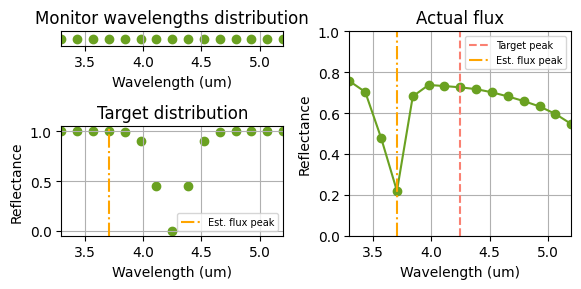

	Finished objective function evaluation.


NotImplementedError: Can't perform multi-frequency autograd with several adjoint sources yet. In the meantime, please construct a single 'Simulation' per output data (can be multi-frequency) and run in parallel using 'web.run_async'. For example, if your problem has 'P' outuput ports, e.g. waveguides, please make a 'Simulation' corresponding to the objective function contribution at each port.

In [21]:
i = 0

while i < number_of_iterations:
    if retrieval == True: 
        i = iteration_num
        retrieval = False

    print(f"Iteration {i + 1}")

    # Compute the value (error) and gradient of the objective function
    val_i, grad_i = val_and_grad_fn(params_i)
    # grad_norm_i = np.linalg.norm(grad_i)

    print(f"\tObjective function error value: {val_i}")

    # Adjusting the step size as the optimization goes on
    step_size = val_i
    optimizer = optax.adam(learning_rate=step_size)
    optimizer_state = optimizer.init(np.concatenate(params_i))

    params_i_concatenated = np.concatenate(params_i)
    grad_i_concatenated = np.concatenate(grad_i)

    # Update the parameters: error (loss) as small as possible
    updates, optimizer_state = optimizer.update(grad_i_concatenated, optimizer_state, params_i_concatenated)
    params_i_concatenated = optax.apply_updates(params_i_concatenated, updates) # params_i is now Jax-traced

    # Restore the original shape of the parameters
    params_i = np.array(params_i_concatenated)
    params_i = np.split(params_i, np.cumsum(shape[:-1]))

    # Save the optimization history
    params_history.append(params_i)
    error_history.append(val_i)
    grad_history.append(grad_i)
    # Simulation data history is stored in sim_data_history in objective_fn

    # Save the current optimization progress in the file
    save_data(file_name, i)

    i = i + 1

## Data Visualization

In [ ]:
# Flux history

fig, axes = plt.subplots(4, 3, figsize = (9, 12))
axes = axes.flatten()
for i, flux in enumerate(fluxes_history):
    # flux = [flux._value for flux in fluxes_history[i]]
    ax = axes[i]
    ax.plot(monitor_wvls, flux, marker='o', color=grass_green)
    ax.set_title(f'Flux at iteration {i+1}')
    ax.set_xlabel('Wavelegnth (um)')
    ax.set_ylabel('Flux')
    ax.set_xlim(wvl_range[0], wvl_range[1])
    ax.set_ylim(0, 1)
    ax.axvline(x=wvl0, color=salmon_red, linestyle='--')
# fig.delaxes(axes[-1]) # Delete the last subplot if number_of_iterations == 5
plt.tight_layout()
plt.savefig("flux_history.png")
plt.show()

In [ ]:
# Error history
plt.figure(figsize=(3, 3))
plt.plot(error_history, marker='o', color=vib_orange)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.xlim((0, 10))
plt.title("Error History")
plt.show()

In [ ]:
%%script echo skip

# Retrieve geometric parameters at the {itr}th iteration
itr = 3
wvl_points_for_checking = 101
wvls_for_checking = np.linspace(wvl_range[0], wvl_range[1], wvl_points_for_checking)
freqs_for_checking = td.constants.C_0 / wvls_for_checking

FLUX_MONITOR_FOR_CHECKING_NAME = 'flux_monitor_for_checking'

monitor_flux_for_checking = td.FluxMonitor(
    center=(0, 0, Lz / 2 - wvl0),
    size=(td.inf, td.inf, 0),
    freqs=freqs_for_checking,
    name=FLUX_MONITOR_FOR_CHECKING_NAME,
)

sim_for_checking = make_sim(params_history[itr-1])
sim_for_checking = sim_for_checking.updated_copy(monitors=[monitor_flux_for_checking])
sim_for_checking.plot_3d()

In [ ]:
%%script echo skip

sim_data_for_checking = web.run(simulation=sim_for_checking, task_name=f"{itr}th_iteration", path=f"data/{itr}th_iteration.hdf5", verbose=False)

In [ ]:
%%script echo skip

reflectance = sim_data_for_checking[FLUX_MONITOR_FOR_CHECKING_NAME].flux

plt.figure(figsize=(3, 3))
plt.plot(wvls_for_checking, reflectance, marker='o', markersize=3, label='Reflectance', color=grass_green)
plt.axvline(x=4.25, color=salmon_red, label='Target', linestyle='--')
plt.xlabel('Wavelengths (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at iteration {itr}')
plt.show()